In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import random
import tensorflow as tf
import shutil


2022-12-22 19:34:11.532524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 19:34:11.713373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 19:34:12.489913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-22 19:34:12.490009: W tensorflow/stream_executor/platform/default/dso_l

### Visualizing dataset

### Magnification Level 1

In [2]:
basePath = os.path.join("project","1")
cancerPath = os.path.join("project","1",'cancer')
benignPath = os.path.join("project","1",'benign')
maskCancerPath = os.path.join("mask","1",'cancer')
maskBenignPath = os.path.join("mask","1",'benign')

cancerDir = list(os.listdir(cancerPath))
maskCancerDir = list(os.listdir(maskCancerPath))
benignDir = list(os.listdir(benignPath))
maskBenignDir = list(os.listdir(maskBenignPath))

cancerDir.sort()
maskCancerDir.sort()
benignDir.sort()
maskBenignDir.sort()

print("No of cancer Images:",len(cancerDir))
print("No of benign Images:",len(benignDir))

No of cancer Images: 7075
No of benign Images: 173766


### Visualizing some of the cancerous slides

(299, 299, 3)
(299, 299)
(299, 299, 3)
(299, 299)


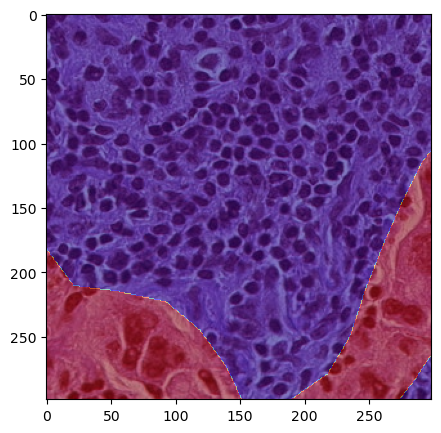

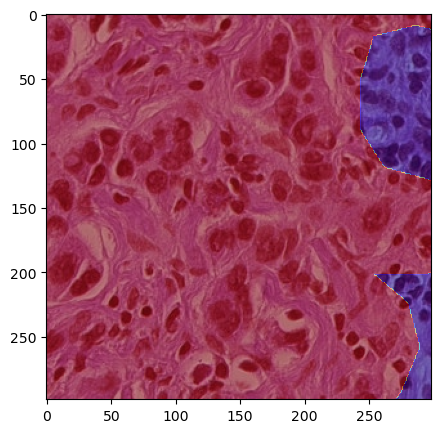

In [3]:
for _ in range(2):
    randomCancerIndex = random.randint(0,len(cancerPath)-1)
    cancerImage = plt.imread(os.path.join(cancerPath,cancerDir[randomCancerIndex]))
    mask = plt.imread(os.path.join(maskCancerPath,cancerDir[randomCancerIndex]))

    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(cancerImage)
    plt.imshow(mask, cmap='jet', alpha=0.5)

    print(cancerImage.shape)
    print(mask.shape)

### Visualzing some of the Non cancerous Slides

(299, 299, 3)
(299, 299)
(299, 299, 3)
(299, 299)


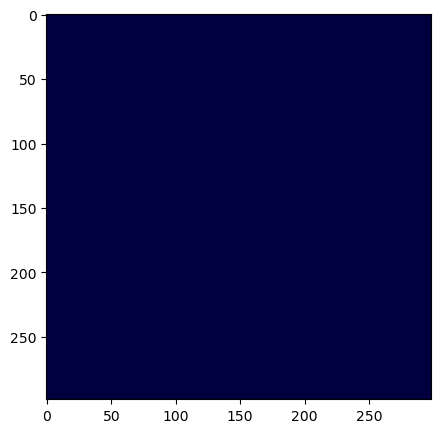

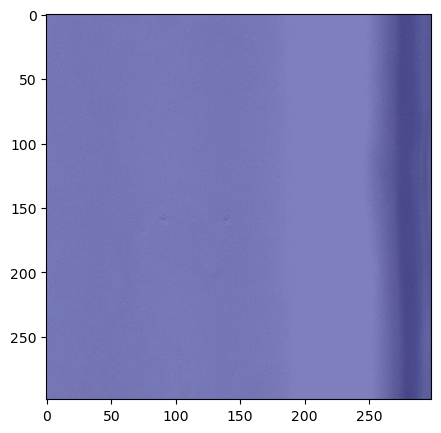

In [4]:
for _ in range(2):
    randomBenignIndex = random.randint(0,len(benignDir)-1)
    benignImage = plt.imread(os.path.join(benignPath,benignDir[randomBenignIndex]))
    mask = plt.imread(os.path.join(maskBenignPath,maskBenignDir[randomBenignIndex]))

    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(benignImage)
    plt.imshow(mask, cmap='jet', alpha=0.5)

    print(benignImage.shape)
    print(mask.shape)

### Creating tf Dataset from the Images  

In [5]:
dataDir = './project/1/'
batch_size = 32
img_ht = 299
img_wd = 299
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = None,subset="training",seed= 123,labels="inferred",label_mode="int")

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = batch_size,subset="validation",seed= 123,labels="inferred",label_mode="int")

Found 180841 files belonging to 2 classes.
Using 162757 files for training.


2022-12-22 05:30:11.030720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:30:11.041084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:30:11.042850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:30:11.045591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 180841 files belonging to 2 classes.
Using 18084 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['benign', 'cancer']


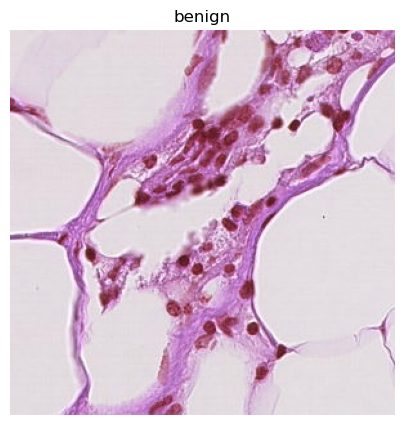

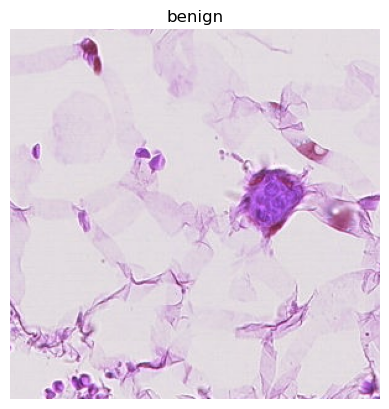

In [9]:
plt.figure(figsize=(5, 5),dpi=100)
for images,labels in train_ds.take(2):

    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels])
    plt.axis("off")
    plt.show()

#### Since we already have a lot of data for benign images we only apply the augmentaion to the cancerous slides 

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.8),
  tf.keras.layers.RandomContrast(0.4),
  tf.keras.layers.RandomBrightness(0.5),
  tf.keras.layers.Rescaling(1./255) 
])

data_augmentation2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255) 
])

def augment(image,label):
    if label==1:
        image = data_augmentation(tf.expand_dims(image, axis=0),training=True) # applying rescaling along with other augmentation techniques
    else:
        image = data_augmentation2(tf.expand_dims(image, axis=0),training=True) # Only applying the rescaling layer
    return tf.squeeze(image),label



In [11]:
train_ds = train_ds.map(lambda x,y: (augment(x,y))).batch(32)

In [12]:
print(train_ds.cardinality())

tf.Tensor(5087, shape=(), dtype=int64)


In [13]:
train_ds = train_ds.shuffle(2*batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

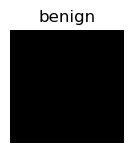

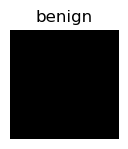

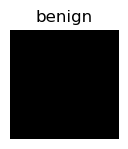

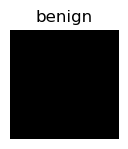

In [15]:
plt.figure(figsize=(5, 5),dpi=100)
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

### Models

In [16]:
from tensorflow.keras.applications import ResNet101
preTrainedModel = ResNet101(include_top=False, weights="imagenet",classes=2,input_shape=(299,299,3))
for layer in preTrainedModel.layers: 
    layer.trainable = False

In [17]:
fineTuneLayer = tf.keras.layers.Flatten()(preTrainedModel.output)
fineTuneLayer = tf.keras.layers.Dense(2048,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(1024,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(512,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dropout(0.35)(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(2,activation="softmax")(fineTuneLayer)
model = tf.keras.Model(preTrainedModel.input,fineTuneLayer)

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(train_ds,validation_data=val_ds,epochs =3)

Epoch 1/3


2022-12-22 05:31:48.033118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


5087/5087 [==============================] - 2426s 474ms/step - loss: 0.3556 - accuracy: 0.9670 - val_loss: 6.0810 - val_accuracy: 0.9637
Epoch 2/3
5087/5087 [==============================] - 2419s 474ms/step - loss: 0.0936 - accuracy: 0.9719 - val_loss: 1.9045 - val_accuracy: 0.9637
Epoch 3/3
5087/5087 [==============================] - 2410s 473ms/step - loss: 0.0764 - accuracy: 0.9750 - val_loss: 3.8618 - val_accuracy: 0.9637


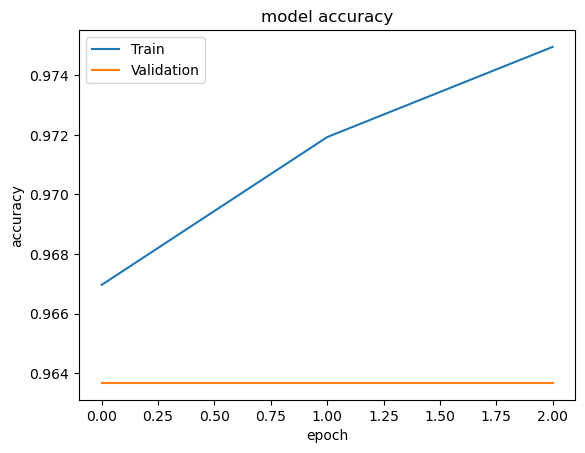

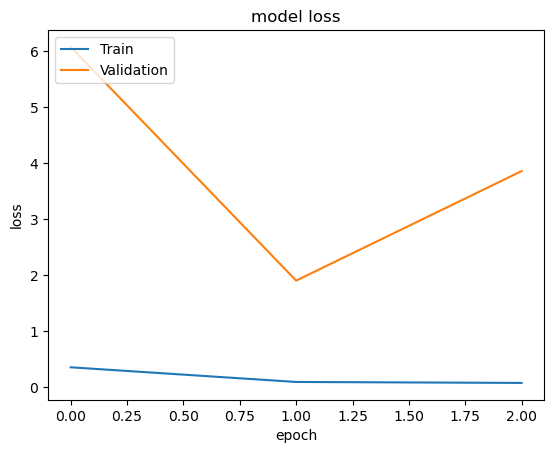

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
trainedModelPath = "./Models"
if not os.path.exists(trainedModelPath):
    os.mkdir(trainedModelPath)
model.save(os.path.join(trainedModelPath,'magLevel1Model.h5'))

### Magnification Level 2

In [3]:
basePath = os.path.join("project","2")
cancerPath = os.path.join("project","2",'cancer')
benignPath = os.path.join("project","2",'benign')
maskCancerPath = os.path.join("mask","2",'cancer')
maskBenignPath = os.path.join("mask","2",'benign')

cancerDir = list(os.listdir(cancerPath))
maskCancerDir = list(os.listdir(maskCancerPath))
benignDir = list(os.listdir(benignPath))
maskBenignDir = list(os.listdir(maskBenignPath))

cancerDir.sort()
maskCancerDir.sort()
benignDir.sort()
maskBenignDir.sort()

print("No of cancer Images:",len(cancerDir))
print("No of benign Images:",len(benignDir))

No of cancer Images: 7885
No of benign Images: 167185


In [4]:
dataDir = './project/2/'
batch_size = 32
img_ht = 299
img_wd = 299
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = None,subset="training",seed= 123,labels="inferred",label_mode="int")

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = 32,subset="validation",seed= 123,labels="inferred",label_mode="int")

Found 175070 files belonging to 2 classes.
Using 157563 files for training.
Found 175070 files belonging to 2 classes.
Using 17507 files for validation.


In [5]:
train_ds = train_ds.map(lambda x,y: (augment(x,y))).batch(32)
train_ds = train_ds.shuffle(2*batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
from tensorflow.keras.applications import ResNet101
preTrainedModel = ResNet101(include_top=False, weights="imagenet",classes=2,input_shape=(299,299,3))
for layer in preTrainedModel.layers: 
    layer.trainable = False

In [7]:
fineTuneLayer = tf.keras.layers.Flatten()(preTrainedModel.output)
fineTuneLayer = tf.keras.layers.Dense(1024,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(256,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(128,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dropout(0.3)(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(2,activation="softmax")(fineTuneLayer)
model = tf.keras.Model(preTrainedModel.input,fineTuneLayer)

In [8]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
history = model.fit(train_ds,validation_data=val_ds,epochs =3)

Epoch 1/3


2022-12-22 13:17:10.823487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


4924/4924 [==============================] - 2163s 436ms/step - loss: 0.2717 - accuracy: 0.9712 - val_loss: 4.0261 - val_accuracy: 0.9554
Epoch 2/3
4924/4924 [==============================] - 2141s 434ms/step - loss: 0.0495 - accuracy: 0.9845 - val_loss: 4.6084 - val_accuracy: 0.9554
Epoch 3/3
4924/4924 [==============================] - 2145s 434ms/step - loss: 0.0402 - accuracy: 0.9875 - val_loss: 4.4834 - val_accuracy: 0.9554


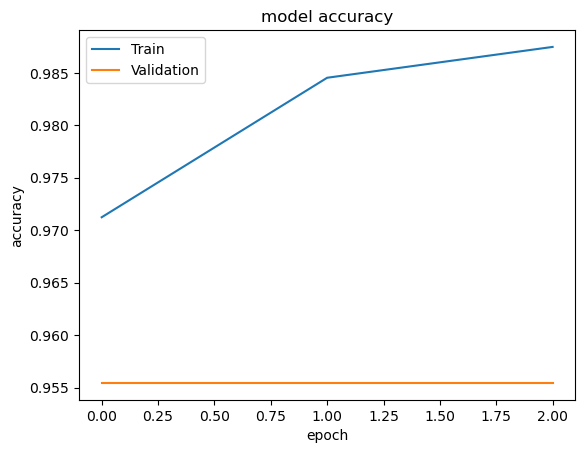

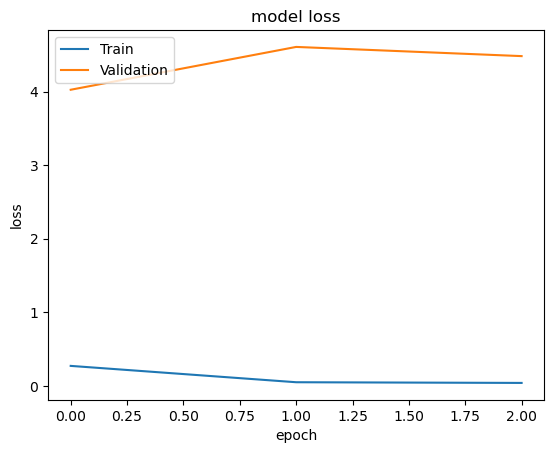

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
trainedModelPath = "./Models"
if not os.path.exists(trainedModelPath):
    os.mkdir(trainedModelPath)
model.save(os.path.join(trainedModelPath,'magLevel2Model.h5'))

### Magnifiation Level 5

In [3]:
basePath = os.path.join("project","5")
cancerPath = os.path.join("project","5",'cancer')
benignPath = os.path.join("project","5",'benign')
maskCancerPath = os.path.join("mask","5",'cancer')
maskBenignPath = os.path.join("mask","5",'benign')

cancerDir = list(os.listdir(cancerPath))
maskCancerDir = list(os.listdir(maskCancerPath))
benignDir = list(os.listdir(benignPath))
maskBenignDir = list(os.listdir(maskBenignPath))

cancerDir.sort()
maskCancerDir.sort()
benignDir.sort()
maskBenignDir.sort()

print("No of cancer Images:",len(cancerDir))
print("No of benign Images:",len(benignDir))

No of cancer Images: 2309
No of benign Images: 14699


In [4]:
dataDir = './project/5/'
batch_size = 32
img_ht = 299
img_wd = 299
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = None,subset="training",seed= 123,labels="inferred",label_mode="int")

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = 32,subset="validation",seed= 123,labels="inferred",label_mode="int")

Found 17008 files belonging to 2 classes.
Using 15308 files for training.


2022-12-22 15:32:22.888798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 15:32:22.974281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 15:32:22.976107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 15:32:22.982428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 17008 files belonging to 2 classes.
Using 1700 files for validation.


In [8]:
train_ds = train_ds.map(lambda x,y: (augment(x,y))).batch(32)
train_ds = train_ds.shuffle(2*batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
from tensorflow.keras.applications import ResNet101
preTrainedModel = ResNet101(include_top=False, weights="imagenet",classes=2,input_shape=(299,299,3))
for layer in preTrainedModel.layers: 
    layer.trainable = False

In [15]:
fineTuneLayer = tf.keras.layers.Flatten()(preTrainedModel.output)
fineTuneLayer = tf.keras.layers.Dense(128,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(64,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(32,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dropout(0.2)(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(2,activation="softmax")(fineTuneLayer)
model = tf.keras.Model(preTrainedModel.input,fineTuneLayer)

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(train_ds,validation_data=val_ds,epochs =10)

Epoch 1/10
479/479 [==============================] - 214s 421ms/step - loss: 1.1104 - accuracy: 0.8426 - val_loss: 2.6838 - val_accuracy: 0.8647
Epoch 2/10
479/479 [==============================] - 205s 414ms/step - loss: 0.4032 - accuracy: 0.8640 - val_loss: 3.3586 - val_accuracy: 0.8647
Epoch 3/10
479/479 [==============================] - 206s 415ms/step - loss: 0.3715 - accuracy: 0.8635 - val_loss: 5.6927 - val_accuracy: 0.8647
Epoch 4/10
479/479 [==============================] - 205s 412ms/step - loss: 0.4536 - accuracy: 0.8626 - val_loss: 3.5930 - val_accuracy: 0.8647
Epoch 5/10
479/479 [==============================] - 205s 413ms/step - loss: 0.3602 - accuracy: 0.8642 - val_loss: 6.1391 - val_accuracy: 0.8647
Epoch 6/10
479/479 [==============================] - 205s 414ms/step - loss: 0.3463 - accuracy: 0.8642 - val_loss: 9.3867 - val_accuracy: 0.8647
Epoch 7/10
479/479 [==============================] - 204s 412ms/step - loss: 0.3208 - accuracy: 0.8646 - val_loss: 12.5859 

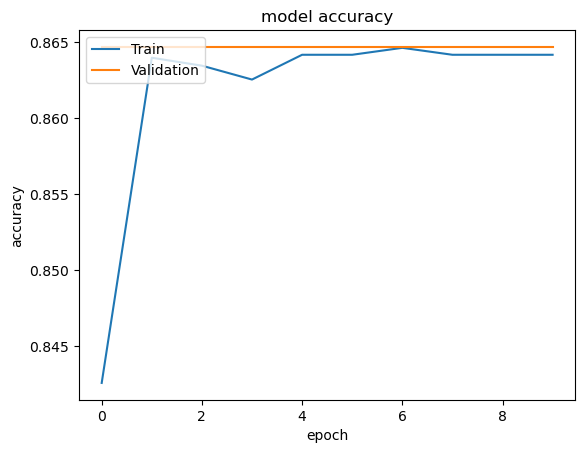

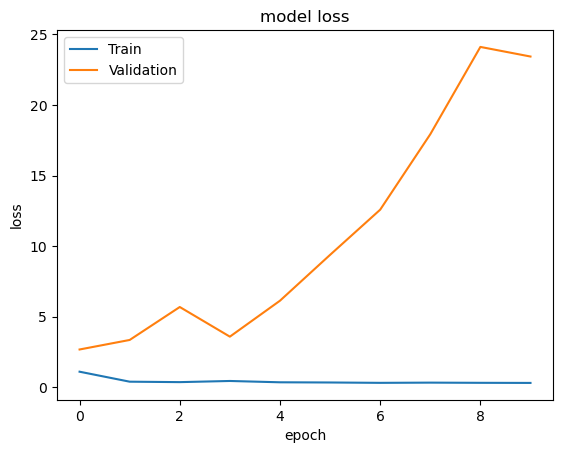

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
trainedModelPath = "./Models"
if not os.path.exists(trainedModelPath):
    os.mkdir(trainedModelPath)
model.save(os.path.join(trainedModelPath,'magLevel5Model.h5'))

### Magnification Level 6

In [20]:
basePath = os.path.join("project","6")
cancerPath = os.path.join("project","6",'cancer')
benignPath = os.path.join("project","6",'benign')
maskCancerPath = os.path.join("mask","6",'cancer')
maskBenignPath = os.path.join("mask","6",'benign')

cancerDir = list(os.listdir(cancerPath))
maskCancerDir = list(os.listdir(maskCancerPath))
benignDir = list(os.listdir(benignPath))
maskBenignDir = list(os.listdir(maskBenignPath))

cancerDir.sort()
maskCancerDir.sort()
benignDir.sort()
maskBenignDir.sort()

print("No of cancer Images:",len(cancerDir))
print("No of benign Images:",len(benignDir))

No of cancer Images: 1449
No of benign Images: 4447


In [21]:
dataDir = './project/6/'
batch_size = 32
img_ht = 299
img_wd = 299
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = None,subset="training",seed= 123,labels="inferred",label_mode="int")

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataDir, validation_split=0.1,image_size =(img_ht,img_wd),batch_size = 32,subset="validation",seed= 123,labels="inferred",label_mode="int")

Found 5896 files belonging to 2 classes.
Using 5307 files for training.
Found 5896 files belonging to 2 classes.
Using 589 files for validation.


In [22]:
train_ds = train_ds.map(lambda x,y: (augment(x,y))).batch(32)
train_ds = train_ds.shuffle(2*batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
from tensorflow.keras.applications import ResNet101
preTrainedModel = ResNet101(include_top=False, weights="imagenet",classes=2,input_shape=(299,299,3))
for layer in preTrainedModel.layers: 
    layer.trainable = False

In [32]:
fineTuneLayer = tf.keras.layers.Flatten()(preTrainedModel.output)
fineTuneLayer = tf.keras.layers.Dense(512,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(2,activation="softmax")(fineTuneLayer)
model = tf.keras.Model(preTrainedModel.input,fineTuneLayer)

In [33]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
history = model.fit(train_ds,validation_data=val_ds,epochs =5)

Epoch 1/5


2022-12-22 18:09:10.957217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 63 of 64
2022-12-22 18:09:11.063536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


166/166 [==============================] - 88s 437ms/step - loss: 5.4299 - accuracy: 0.7004 - val_loss: 8.9106 - val_accuracy: 0.6197
Epoch 2/5
166/166 [==============================] - 80s 431ms/step - loss: 0.6801 - accuracy: 0.7793 - val_loss: 9.4441 - val_accuracy: 0.7657
Epoch 3/5
166/166 [==============================] - 80s 430ms/step - loss: 0.4022 - accuracy: 0.8295 - val_loss: 5.4329 - val_accuracy: 0.7385
Epoch 4/5
166/166 [==============================] - 80s 430ms/step - loss: 0.3390 - accuracy: 0.8798 - val_loss: 3.9727 - val_accuracy: 0.7199
Epoch 5/5
166/166 [==============================] - 80s 430ms/step - loss: 0.3127 - accuracy: 0.8866 - val_loss: 3.3528 - val_accuracy: 0.6808


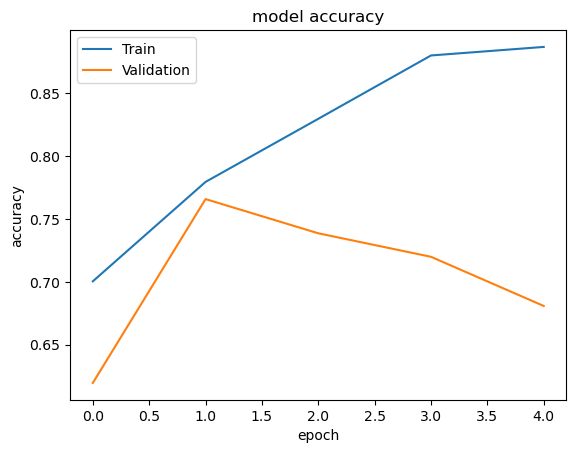

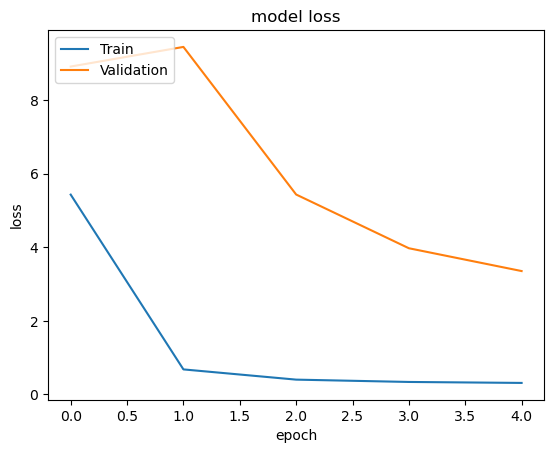

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
trainedModelPath = "./Models"
if not os.path.exists(trainedModelPath):
    os.mkdir(trainedModelPath)
model.save(os.path.join(trainedModelPath,'magLevel6Model.h5'))

### Model That gives selects the most probable Magnification level for a Image

#### We will use 5k images from each magnification level to create the model 

In [2]:
dataDir = './project/6/'
img_ht = 299
img_wd = 299
train6_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,image_size =(img_ht,img_wd),batch_size = None,seed= 123,labels="inferred",label_mode="int")

Found 5896 files belonging to 2 classes.


2022-12-22 19:34:34.500758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 19:34:34.624378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 19:34:34.626194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 19:34:34.632861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
dataDir = './project/5/'
img_ht = 299
img_wd = 299
train5_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, image_size =(img_ht,img_wd),batch_size = None,seed= 123,labels="inferred",label_mode="int")

Found 17008 files belonging to 2 classes.


In [11]:
dataDir = './project/2/'
img_ht = 299
img_wd = 299
train2_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, image_size =(img_ht,img_wd),batch_size = None,seed= 123,labels="inferred",label_mode="int")

Found 175070 files belonging to 2 classes.


In [12]:
dataDir = './project/1/'
img_ht = 299
img_wd = 299
train1_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir, image_size =(img_ht,img_wd),batch_size = None,seed= 123,labels="inferred",label_mode="int")

Found 180841 files belonging to 2 classes.


In [5]:
def setYLabel(image,label,setValue):
    return (image,setValue)

In [75]:
d6 = train6_ds.take(5000)
d5 = train5_ds.take(5000)
d2 = train2_ds.take(5000)
d1 = train1_ds.take(5000)

d6 = d6.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(3,num_classes =4)))
d5 = d5.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(2,num_classes =4)))
d2 = d2.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(1,num_classes =4)))
d1 = d1.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(0,num_classes =4)))


In [90]:
for image, label in d6.take(4):
    print(image.shape)
    print(label.shape)

(299, 299, 3)
(4,)
(299, 299, 3)
(4,)
(299, 299, 3)
(4,)
(299, 299, 3)
(4,)


##### Creating a Training Set with Images and their magnification level as label

In [77]:
train = d1.concatenate(d2).concatenate(d5).concatenate(d6)

In [78]:
train = train.batch(32)

In [79]:
print(train.cardinality())

tf.Tensor(625, shape=(), dtype=int64)


In [99]:
train=train.shuffle(2*32)

##### Creating a validation Set (Taking 500 images from each)

In [80]:
d6 = train6_ds.skip(5000)
d5 = train5_ds.skip(5000)
d2 = train2_ds.skip(5000)
d1 = train1_ds.skip(5000)

d6 = train6_ds.take(500)
d5 = train5_ds.take(500)
d2 = train2_ds.take(500)
d1 = train1_ds.take(500)

d6 = d6.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(3,num_classes =4)))
d5 = d5.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(2,num_classes =4)))
d2 = d2.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(1,num_classes =4)))
d1 = d1.map(lambda x,y: setYLabel(x,y,tf.keras.utils.to_categorical(0,num_classes =4)))


In [81]:
val = d1.concatenate(d2).concatenate(d5).concatenate(d6)

In [82]:
val = val.batch(32)

In [100]:
val=val.shuffle(2*32)

In [101]:
print(val.cardinality())

tf.Tensor(63, shape=(), dtype=int64)


#### Magnification Level classification Model

In [95]:
from tensorflow.keras.applications import ResNet101
preTrainedModel = ResNet101(include_top=False, weights="imagenet",classes=4,input_shape=(299,299,3))
for layer in preTrainedModel.layers: 
    layer.trainable = False

In [96]:
fineTuneLayer = tf.keras.layers.Flatten()(preTrainedModel.output)
fineTuneLayer = tf.keras.layers.Dense(1024,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(128,activation="relu")(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dropout(0.2)(fineTuneLayer)
fineTuneLayer = tf.keras.layers.Dense(4,activation="softmax")(fineTuneLayer)
model = tf.keras.Model(preTrainedModel.input,fineTuneLayer)

In [97]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [102]:
history = model.fit(train,validation_data=val,epochs =3)

Epoch 1/3
625/625 [==============================] - 234s 369ms/step - loss: 5.0543 - accuracy: 0.5005 - val_loss: 1.4153 - val_accuracy: 0.2760
Epoch 2/3
625/625 [==============================] - 233s 369ms/step - loss: 1.7653 - accuracy: 0.4654 - val_loss: 1.3903 - val_accuracy: 0.3155
Epoch 3/3
625/625 [==============================] - 234s 370ms/step - loss: 2.5417 - accuracy: 0.5189 - val_loss: 1.4613 - val_accuracy: 0.3125


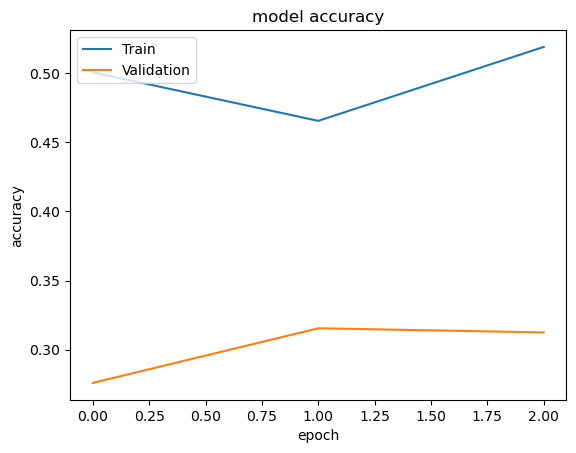

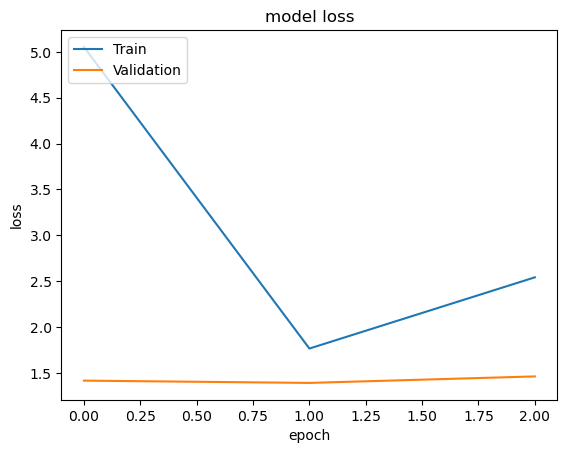

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [103]:
trainedModelPath = "./Models"
if not os.path.exists(trainedModelPath):
    os.mkdir(trainedModelPath)
model.save(os.path.join(trainedModelPath,'magLevelClassifier.h5'))